In [85]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from src.Autoencoder import Autoencoder as AE
from src.early_stopping import EarlyStopping
from tqdm import tqdm
from sklearn.utils import shuffle



In [86]:

path = '../../data/input/GTEx/GTEx_mini_rando.gct'
gtex_df = pd.read_csv(path, skiprows=2, sep="\t", nrows=1000)


In [87]:

# Drop zero columns
gtex_df = gtex_df.loc[:, (gtex_df != 0).any(axis=0)]

In [88]:
train_df, test_df = train_test_split(gtex_df, test_size=0.2, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.25, shuffle=True)

In [89]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

600
200
200


In [90]:
# define hparams
hparams = {
    "input_size": len(gtex_df.columns) - 2,
    "emb_dim": 128,    
}
config = {
    "epochs": 100,
    "batch_size": 265,
    "lr": 1e-5
}

device = "cpu"

In [91]:
class GTExDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.gene_ids = self.df['Name']
        # drop first 2 columns
        self.df.drop(self.df.columns[[0, 1]], axis=1, inplace=True)
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(self.df.to_numpy())
        self.df = pd.DataFrame(df_scaled)

    def get_gene_ids(self):
        return self.gene_ids
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        features = torch.tensor(self.df.iloc[idx], dtype=torch.float32)

        if self.transform:
            features = self.transform(features)

        return features, features # for Autoencoder

In [92]:
train_dataset = GTExDataset(train_df)
val_dataset = GTExDataset(val_df)
test_dataset = GTExDataset(test_df)
full_dataset = GTExDataset(gtex_df)
# Define DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=config['batch_size'], shuffle=False)

In [93]:
# Initialize model, loss function, and optimizer
model = AE(hparams["input_size"], hparams["emb_dim"])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
train_loss_values = []
val_loss_values = []

def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)
epochs = config['epochs']
es = EarlyStopping(patience=5)
# Training loop
for epoch in range(epochs):
    # Train step
    model.train()
    training_loss = 0
    training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')

    for train_iteration, batch in training_loop:
        optimizer.zero_grad() # Reset the gradients - VERY important! Otherwise they accumulate.
        inputs, targets = batch[0].to(device), batch[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        # Update the progress bar.
        training_loop.set_postfix(curr_train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)))
    training_loss /= len(train_loader)
    train_loss_values.append(training_loss)
    # Val step
    model.eval()
    validation_loss = 0
    val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
    with torch.no_grad():
        for val_iteration, batch in val_loop:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
            # Update the progress bar.
            val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))
    validation_loss /= len(val_loader)
    val_loss_values.append(validation_loss)
    if es.early_stop(validation_loss): 
        print(f"Early stopping at this epoch: {epoch}")
        break
print("Finished training!")


Validation Epoch [100/100]: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.72it/s, val_loss=0.82996386]

Finished training!


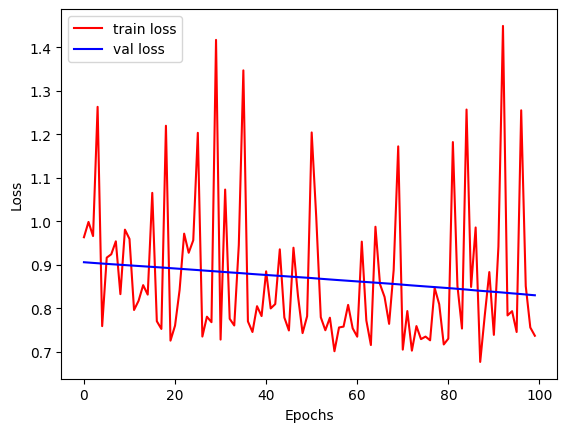

In [94]:
with torch.no_grad():
    plt.plot(np.array(train_loss_values), 'r', label='train loss')
    plt.plot(np.array(val_loss_values), 'b', label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
embeddings = []
# Extract embeddings
with torch.no_grad():
    model.eval()
    for inputs, _ in full_loader:
        x = model.encoder(inputs)
        embeddings.append(x)
embeddings = torch.vstack(embeddings)
len(embeddings)

In [ ]:

emb_df = pd.DataFrame(
    data = embeddings,
    index = full_dataset.get_gene_ids(),
    columns = [f'EMB_{i}' for i in range(hparams["emb_dim"])]
)
emb_df.index.name = "gene_id"
emb_df

In [ ]:
emb_df.index = emb_df.index.str.split('.').str[0]
emb_df

In [ ]:
emb_df.to_csv(f"../../data/embeddings/GTEx_AE_embeddings.tsv", sep="\t")